In [1]:
'''
TODO:
1. Нормализовать значения
2. Удалить схемы
3. Освещение и тяжесть -> int

PROBLEMS:


Границы СПб:
            from        to
latitude    59.63       60.24
longitude   29.42       30.76
'''

'\nTODO:\n1. Нормализовать значения\n2. Удалить схемы\n3. Освещение и тяжесть -> int\n\nPROBLEMS:\n\n\nГраницы СПб:\n            from        to\nlatitude    59.63       60.24\nlongitude   29.42       30.76\n'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from io import StringIO
from csv import writer
from IPython.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
# функция для преобразования кода съемы в HTML-код изображения на сервере сайта dtp-stat.ru

def path_to_image_html(path):
    return '<img src="https://dtp-stat.ru/static/scheme/'+ path + '.png">'

In [4]:
# функция для подготовки One-Hot кодирования столбца, в котором данные имеют вид списков
# возвращает набор присутствующих значений и DataFrame-объект закодированной таблицы 

def one_hot_prepare(datacol):      
    ohe_cols = []
    for value in datacol.values:
        for i in range(len(value)):
            if value[i] not in ohe_cols:
                ohe_cols.append(value[i])
                
    res = dict(zip(ohe_cols, [[None]*len(datacol) for _ in ohe_cols]))
    
    for i, value in enumerate(datacol):
        for col in ohe_cols:
            if col in value:
                res[col][i] = 1
            else:
                res[col][i] = 0      
    return ohe_cols, res
    

In [5]:
# функция для осуществления One-Hot кодирования указанных столбцов в заданной таблице

def one_hot_encoding(data, columns):
    for column in columns:
        ohe_headers, ohe_data = one_hot_prepare(data[column])
        for header in ohe_headers:
           data[header] = ohe_data[header]
        data = data.drop(columns=column)
    return data        

In [6]:
with open("spb.geojson", encoding='utf-8') as f:
    data = pd.read_json(f)

In [7]:
# извлекаем нужные данные путём нормализации json'a
# в несколько этапов - для того, чтобы не было лишних префиксов

data = pd.json_normalize(data['features'], sep='_', max_level=0)
data = pd.json_normalize(data['properties'], sep='_')

In [8]:
# удаляем лишние столбцы и фильтруем данные, оставляя связанные с перекрёстками (согласно схемам)

cutted = data.drop(columns=['id', 'gibdd_id', 'participant_categories', 'parent_region', 'address', 'vehicles', 'participants', 'tags'])
cutted.dropna(inplace=True)
scheme_filter = ['100', '110', '120', '130', '300', '310', '320', '340', '400', '410', '420', '430', '440', 
                 '700', '710', '720', '730', '760', '770', '780']
cutted = cutted[cutted.scheme.isin(scheme_filter)]

In [9]:
# удаляем всё, что за пределами СПб по координатам

lat_min = 59.63
lat_max = 60.24
long_min = 29.42
long_max = 30.76
cutted = cutted[(cutted.point_lat > lat_min) & (cutted.point_lat < lat_max) &
                (cutted.point_long > long_min) & (cutted.point_long < long_max)]

In [10]:
# визуализируем схемы ДТП

pd.set_option('display.max_colwidth', None)
format_dict = {'scheme': path_to_image_html}
display(HTML(cutted.tail(3).to_html(escape=False ,formatters=format_dict)))

,severity,region,datetime,participants_count,injured_count,dead_count,category,light,nearby,weather,road_conditions,scheme,point_lat,point_long
39445,Тяжелый,Адмиралтейский район,2017-02-13 14:40:00,2,1,0,Наезд на пешехода,Светлое время суток,"[Мост, Регулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.908300,30.27610
39446,Легкий,Адмиралтейский район,2017-02-24 21:00:00,2,1,0,Наезд на пешехода,"В темное время суток, освещение включено","[Многоквартирные жилые дома, Регулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.924190,30.30814
39447,Легкий,Адмиралтейский район,2017-02-21 01:00:00,2,1,0,Наезд на пешехода,Светлое время суток,"[Многоквартирные жилые дома, Нерегулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.914313,30.29749


In [11]:
# преобразуем datetime в месяц, день недели и время

datetime = cutted['datetime']
month = []
day = []
timestamp = []
for row in datetime:
    day.append(pd.to_datetime(row).dayofweek)
    row = row.split(' ')
    month.append(row[0].split('-')[1])
    time = row[1][:-3].split(':')
    timestamp.append(int(time[1]) + int(time[0]) * 60)
    

cutted['month'] = month
cutted['day'] = day
cutted['timestamp'] = timestamp
cutted = cutted.drop(columns='datetime')

In [12]:
# приводим категориальные переменные к формату числовых с помощью One-Hot кодирования

# result = pd.get_dummies(cutted, columns=['category'], prefix=['Категория'])
result = one_hot_encoding(cutted, ['weather', 'nearby', 'road_conditions'])

In [13]:
daylight = 'Светлое время суток'
twilight = 'Сумерки'
night_light_wo = 'В темное время суток, освещение отсутствует'
night_light_off = 'В темное время суток, освещение не включено'
night_light_on = 'В темное время суток, освещение включено'
result['light'] = result['light'].map({daylight: 10, twilight: 5, night_light_on: 3, night_light_off: 0, night_light_wo: 0})
result = result.drop(columns=['region', 'category'])
result.tail(3)

,severity,participants_count,injured_count,dead_count,light,scheme,point_lat,point_long,month,day,...,Неудовлетворительное состояние обочин,Отсутствие временных ТСОД в местах проведения работ,Свежеуложенная поверхностная обработка,Со снежным накатом,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Низкие сцепные качества покрытия,Неисправное освещение,Ограничение видимости,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см"
39445,Тяжелый,2,1,0,10,700,59.908300,30.27610,02,0,...,0,0,0,0,0,0,0,0,0,0
39446,Легкий,2,1,0,3,730,59.924190,30.30814,02,4,...,0,0,0,0,0,0,0,0,0,0
39447,Легкий,2,1,0,10,700,59.914313,30.29749,02,1,...,0,0,0,0,0,0,0,0,0,0


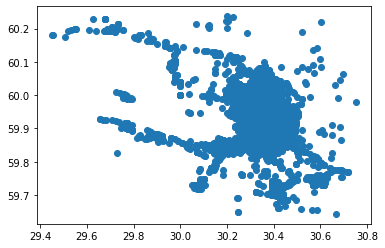

In [14]:
# строим карту записей: видно, что охвачен почти весь город

x = result[['point_lat', 'point_long']].round(4)
# transformer = Normalizer().fit(x)
# normalized = transformer.transform(x)
plt.scatter(x['point_long'], x['point_lat'])

In [15]:
# расчет тяжести аварии

result['severity'] = result['participants_count'] * 1 + result['injured_count'] * 5 + result['dead_count'] * 70
result = result.drop(columns=['participants_count', 'injured_count', 'dead_count'])

result = result.drop(columns=['scheme'])
result.tail(3)

,severity,light,point_lat,point_long,month,day,timestamp,Ясно,Пасмурно,Снегопад,...,Неудовлетворительное состояние обочин,Отсутствие временных ТСОД в местах проведения работ,Свежеуложенная поверхностная обработка,Со снежным накатом,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Низкие сцепные качества покрытия,Неисправное освещение,Ограничение видимости,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см"
39445,7,10,59.908300,30.27610,02,0,880,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39446,7,3,59.924190,30.30814,02,4,1260,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39447,7,10,59.914313,30.29749,02,1,60,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
scaler = MinMaxScaler()
scaler.fit(result)
scaled = scaler.fit_transform(result)
scaled_result = pd.DataFrame(scaled, columns=result.columns)
scaled_result.tail(3)

,severity,light,point_lat,point_long,month,day,timestamp,Ясно,Пасмурно,Снегопад,...,Неудовлетворительное состояние обочин,Отсутствие временных ТСОД в местах проведения работ,Свежеуложенная поверхностная обработка,Со снежным накатом,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Низкие сцепные качества покрытия,Неисправное освещение,Ограничение видимости,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см"
8145,0.0,1.0,0.446395,0.633499,0.090909,0.000000,0.611961,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8146,0.0,0.3,0.473162,0.658061,0.090909,0.666667,0.876217,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8147,0.0,1.0,0.456524,0.649897,0.090909,0.166667,0.041725,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

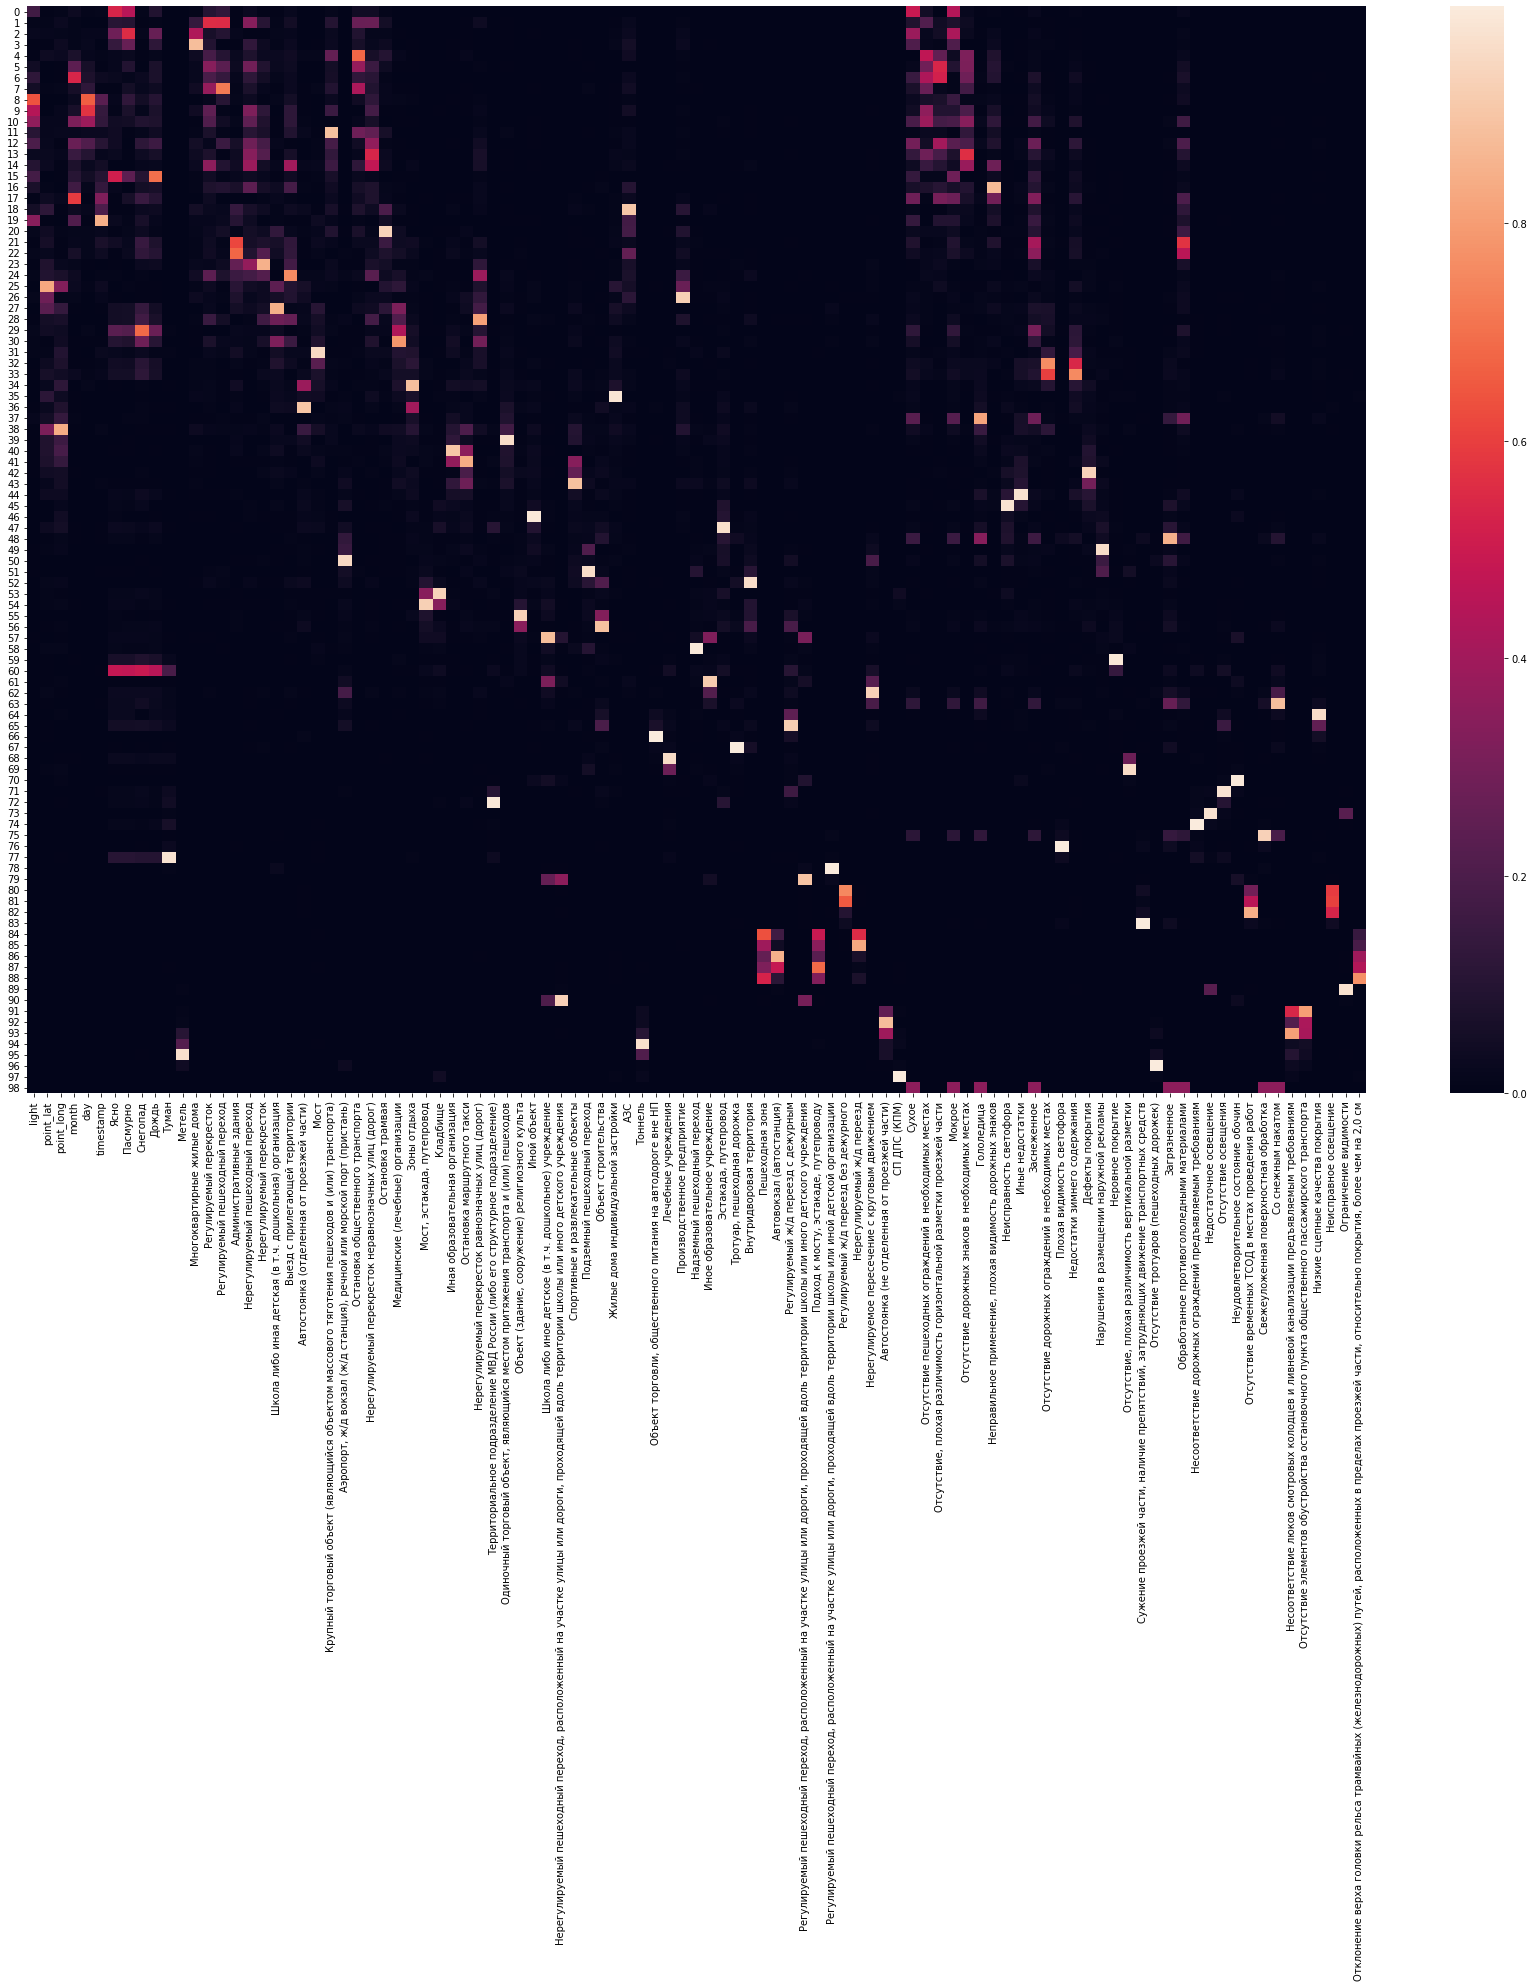

In [24]:
pca = PCA()
pca.fit(scaled_result.drop(columns='severity'))
num = pca.components_.shape[0]

# total impact is sum(explained_variance_ratio_[j] * components[i][j])
impact = np.zeros(num)
for i in range(len(pca.components_)):
    for j in range(len(pca.explained_variance_ratio_)):
        impact[i] += abs(pca.components_[i][j]*pca.explained_variance_ratio_[j])

# for i, col in enumerate(scaled_result.drop(columns='severity').columns):
#     print('{0} -------> {1}%'.format(col, impact[i]))
fig = plt.gcf()
fig.set_size_inches(30, 20)
sns.heatmap(pd.DataFrame(pca.components_, columns=list(scaled_result.drop(columns='severity').columns)).abs())